#Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
from operator import index


#Function definition

In [ ]:
def get_options(ticker, start_date, finish_date,valuation_date):
  start_date=pd.to_datetime(start_date,format="%m/%d/%Y")
  finish_date=pd.to_datetime(finish_date,format="%m/%d/%Y")
  #trade_date=pd.to_datetime(trade_date,format="%m/%d/%Y")
  valuation_date=pd.to_datetime(valuation_date)
  Ticker=yf.Ticker(ticker)
  exp_date=pd.to_datetime(Ticker.options)
  valid_expires=exp_date[(exp_date>=start_date)&(exp_date<=finish_date)]
  options_data=[]

  Underlying=Ticker.fast_info['last_price']
  if Underlying is None:
    Underlying=Ticker.history(period="1d").iloc[-1]

  for expiry in valid_expires:
    chain=Ticker.option_chain(expiry.strftime("%Y-%m-%d"))
    dte=max(1/365,(expiry-valuation_date).days/365)
    calls=chain.calls.assign(expiry=expiry,type="call",Spot=Underlying,T=dte)
    puts=chain.puts.assign(expiry=expiry,type="put",Spot=Underlying,T=dte)
    options_data.append(pd.concat([calls,puts],ignore_index=True))

  df = pd.concat(options_data, ignore_index=True)
  df["valuation_date"] = valuation_date
  return df

In [ ]:
def d1_d2(S,K,r,q,sigma,T):
  d1=(np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
  d2=d1-sigma*np.sqrt(T)
  return d1,d2

def vega(S,K,r,q,sigma,T):
  #return S*np.sqrt(T)*norm.pdf(d1_d1(S,K,r,sigma,T)[0])
  return S*np.exp(-q*T)*np.sqrt(T)*norm.pdf(d1_d2(S,K,r,q,sigma,T)[0])

def C_bs(S,K,r,q,sigma,T):
  #return S*norm.cdf(d1_d1(S,K,r,sigma,T)[0])-K*np.exp(-r*T)*norm.cdf(d1_d1(S,K,r,sigma,T)[1])
  return S*np.exp(-q*T)*norm.cdf(d1_d2(S,K,r,q,sigma,T)[0])-K*np.exp(-r*T)*norm.cdf(d1_d2(S,K,r,q,sigma,T)[1])

def P_bs(S,K,r,q,sigma,T):
  #return K*np.exp(-r*T)*norm.cdf(-d1_d1(S,K,r,sigma,T)[1])-S*norm.cdf(-d1_d1(S,K,r,sigma,T)[0])
  return K*np.exp(-r*T)*norm.cdf(-d1_d2(S,K,r,q,sigma,T)[1])-S*np.exp(-q*T)*norm.cdf(-d1_d2(S,K,r,q,sigma,T)[0])


def iv(initial_guess,mkt_price,S,K,r,q,T,c_p,tol=1e-6,max_iter=50):
  def price_diff(sigma):
    if c_p=='call':
      return C_bs(S,K,r,q,sigma,T)-mkt_price
    else:
      return P_bs(S,K,r,q,sigma,T)-mkt_price
  lower_bound,higher_bound=1e-6,20

  try:
    if price_diff(lower_bound)*price_diff(higher_bound)>0:
      return np.nan
    return brentq(price_diff,lower_bound,higher_bound,xtol=tol,maxiter=max_iter)
  except Exception:
    return np.nan


  '''sigma=initial_guess #newton rapshon
  for i in range(max_iter):
    if c_p=='call':
      price=C_bs(S,K,r,q,sigma,T)
    else:
      price=P_bs(S,K,r,q,sigma,T)
    Vega=vega(S,K,r,q,sigma,T)

    if Vega < 1e-8:
      return np.nan
    diff=price-mkt_price
    if abs(diff)<tol:
      return sigma
    sigma = max(1e-6, sigma - diff/Vega)
  return sigma'''

def q_putcall(options):
  call_put=options.pivot_table(
      index=["expiry",'strike'],
      columns='type',
      values='mid'
  ).dropna()

  meta=options.groupby(['expiry','strike'])[['Spot','rf','T']].first()
  call_put=call_put.join(meta)

  q = -(1/call_put["T"])*np.log(
        (call_put["call"]-call_put["put"]
         +call_put.index.get_level_values("strike")
           *np.exp(-call_put["rf"]*call_put["T"]))
        /call_put["Spot"]
    )

  return q

def db_setup(options,rf):
  '''OTM_options=options.loc[options['inTheMoney']==False].copy()
  OTM_options['rf']=np.interp(OTM_options['T']*365,sofr_df['GG'],sofr_df['Rate'])
  OTM_options['mid']=(OTM_options['bid']+OTM_options['ask'])/2'''
  df=options.copy()
  df['rf']=np.interp(df['T']*365,rf['GG'],rf['Rate'])
  df['mid']=(df['bid']+df['ask'])/2
  q=q_putcall(df)
  OTM_options=df.loc[options['inTheMoney']==False].copy()

  OTM_options=OTM_options[
      (OTM_options['T']>0)&
      (OTM_options['mid']>0.05)&
      ((OTM_options['volume']>0)|(OTM_options['openInterest']>10))&
      (OTM_options['rf'].notna())
  ].copy()

  OTM_options['moneyness']=OTM_options['strike']/OTM_options['Spot']
  OTM_options=OTM_options[
      (OTM_options['moneyness']>0.5)&
      (OTM_options['moneyness']<2.0)
  ].copy()

  #OTM_options['q']=q
  OTM_options['q']=OTM_options.set_index(['expiry','strike']).index.map(q)
  return OTM_options

In [ ]:
def plot_vol_surface(df):

    df['moneyness']=df['strike']/df['Spot']
    plot_df=df.dropna(subset=['calculated_iv','T','moneyness'])

    x = plot_df['moneyness']
    y = plot_df['T']*365
    z = plot_df['calculated_iv']

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111,projection='3d')
    surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('Moneyness (K/S)')
    ax.set_ylabel('Days to Expiry')
    ax.set_zlabel('Implied Volatility')

    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(elev=30, azim=135)

    plt.show()


#Variable set up

In [ ]:

start_date  = "04/23/2025"
finish_date = "12/20/2030"
expiry_selected="2026-01-22"#Expiration date i want to perform the analysis on
#trade_date="04/23/2025"
div_yield=0.013
ticker = "^SPX"
valuation_date = pd.Timestamp("2026-01-16")

snapshot_file = f"{ticker}_options_{valuation_date.date()}.parquet"

try:
    options_list = pd.read_parquet(snapshot_file)
except FileNotFoundError:
    options_list = get_options(ticker, start_date, finish_date, valuation_date)
    options_list.to_parquet(snapshot_file)

# recover valuation_date from file (so you can’t accidentally mismatch later)
valuation_date = pd.to_datetime(options_list["valuation_date"].iloc[0])

#options_list=get_options(ticker,start_date,finish_date,valuation_date)
sofr={
    "Term": ["1 Year", "2 Year", "3 Year", "5 Year", "7 Year", "10 Year", "15 Year", "30 Year"],
    "GG": [365, 730, 1095, 1825, 2555, 3650, 5475, 10950],
    "Rate": [0.0376, 0.0345, 0.0341, 0.0351, 0.0363, 0.0378, 0.0395, 0.0392]
}
sofr_df=pd.DataFrame(sofr)

#Database set up

In [ ]:
#OTM_options=db_setup(options_list,sofr_df,div_yield)
OTM_options=db_setup(options_list,sofr_df)

theor_iv=OTM_options.apply(
    lambda row: iv(0.2,row['mid'],row['Spot'],row['strike'],row['rf'],row['q'],row['T'],row['type']),axis=1
)

In [ ]:
OTM_options['calculated_iv']=theor_iv
comparison_df=OTM_options.dropna(subset=['calculated_iv','impliedVolatility']).copy()

In [ ]:
cols_to_keep = ['expiry', 'type', 'strike', 'Spot','rf','q', 'T', 'mid', 'impliedVolatility', 'calculated_iv']
comparison_df = comparison_df[cols_to_keep].copy()
comparison_df['diff_bps'] = (comparison_df['calculated_iv'] - comparison_df['impliedVolatility']) * 10000

comparison_df.head()

,expiry,type,strike,Spot,rf,q,T,mid,impliedVolatility,calculated_iv,diff_bps
75,2026-01-20,call,6945.0,6940.009766,0.0376,0.001590,0.010959,17.65,0.080423,0.064694,-157.285957
76,2026-01-20,call,6950.0,6940.009766,0.0376,0.000959,0.010959,15.00,0.078798,0.063369,-154.291911
77,2026-01-20,call,6955.0,6940.009766,0.0376,0.001644,0.010959,12.55,0.076700,0.062106,-145.937679
78,2026-01-20,call,6960.0,6940.009766,0.0376,0.001671,0.010959,10.35,0.074907,0.060822,-140.845291
79,2026-01-20,call,6965.0,6940.009766,0.0376,0.001698,0.010959,8.40,0.073435,0.059581,-138.540124


In [ ]:
comparison_target=comparison_df[comparison_df['expiry']==pd.to_datetime(expiry_selected)].copy()

In [ ]:
comparison_target.head()

,expiry,type,strike,Spot,rf,q,T,mid,impliedVolatility,calculated_iv,diff_bps
607,2026-01-22,call,6945.0,6940.009766,0.0376,-0.000868,0.016438,30.95,0.103750,0.088027,-157.227811
608,2026-01-22,call,6950.0,6940.009766,0.0376,-0.000841,0.016438,28.10,0.101922,0.086784,-151.380701
609,2026-01-22,call,6955.0,6940.009766,0.0376,-0.000813,0.016438,25.40,0.100320,0.085592,-147.287510
610,2026-01-22,call,6960.0,6940.009766,0.0376,-0.000786,0.016438,22.85,0.098936,0.084437,-144.987588
611,2026-01-22,call,6965.0,6940.009766,0.0376,-0.000321,0.016438,20.40,0.097124,0.083221,-139.027599


#Plots

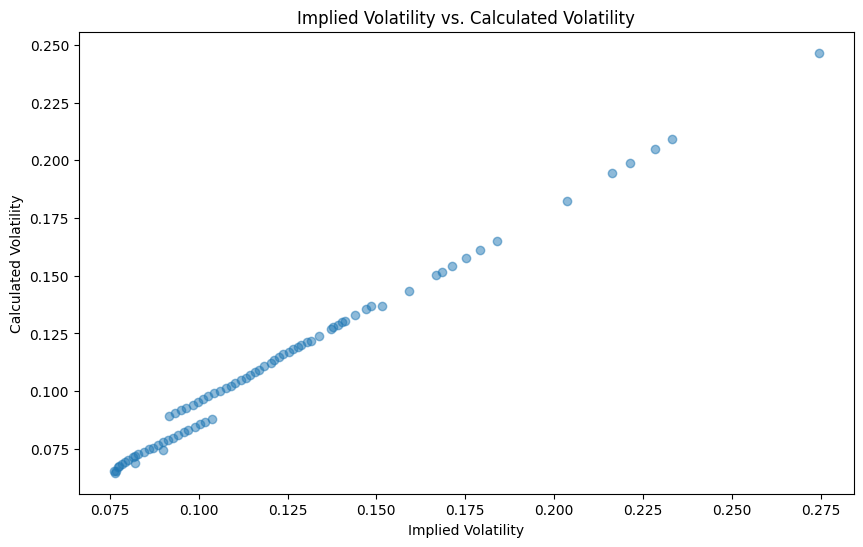

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(comparison_target['impliedVolatility'], comparison_target['calculated_iv'], alpha=0.5)
plt.xlabel('Implied Volatility')
plt.ylabel('Calculated Volatility')
plt.title('Implied Volatility vs. Calculated Volatility')
plt.show()

In [ ]:
comparison_target[
    (comparison_target["impliedVolatility"] < 0.08) &
    (comparison_target["calculated_iv"] < 0.06)
][[
    "type", "strike", "mid",
    "impliedVolatility", "calculated_iv","Spot"
]].sort_values("strike")


,type,strike,mid,impliedVolatility,calculated_iv,Spot


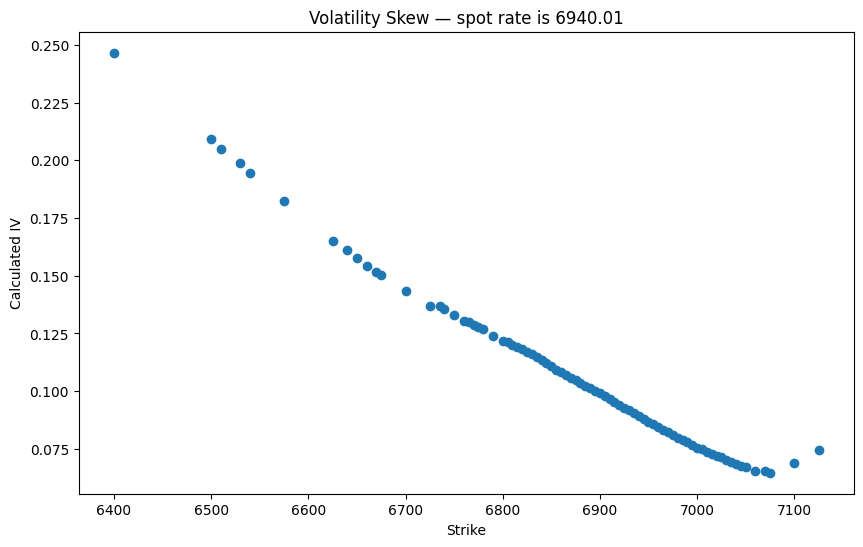

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(comparison_target['strike'],comparison_target['calculated_iv'])
plt.xlabel('Strike')
plt.ylabel('Calculated IV')
plt.title(f"Volatility Skew — spot rate is {comparison_target['Spot'].iloc[0]:.2f}")
plt.show()

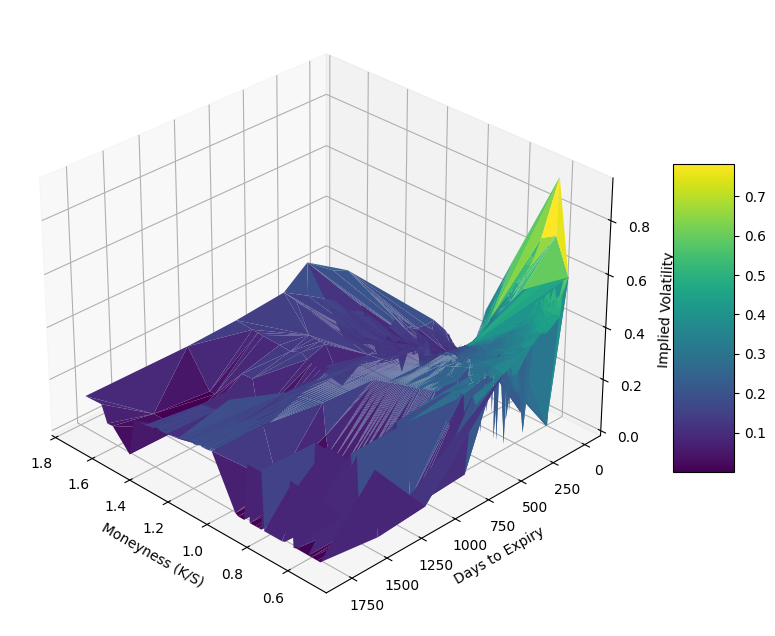

In [ ]:
plot_vol_surface(comparison_df)